In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hottbox.core import Tensor, TensorTKD
from hottbox.algorithms.decomposition import HOSVD, HOOI
from hottbox.utils.generation import residual_tensor
from coursework.data import get_image, plot_tensors

In [3]:
np.random.seed(0)

[Return to Table of Contents](./0_Table_of_contents.ipynb)

# Tucker Decomposition

<img src="./imgs/TensorTKD.png" alt="Drawing" style="width: 500px;"/>

In previous [assignment](./2_Efficient_representation_of_multidimensional_arrays.ipynb), you have been provided materials which cover efficient representations of mutlidimensional arrays of data, such as the Tucker form. In this module, you will take a closer look at it and the assiciated computational methods.


Any tensor of arbitrarily large order can be decomposed in the Tucker form. As illustrated above, a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I \times J \times K}$ can be represented as a dense core tensor $\mathbf{\underline{G}}$ and a set of factor matrices $\mathbf{A} \in \mathbb{R}^{I \times Q}, \mathbf{B} \in \mathbb{R}^{J \times R}$ and $\mathbf{C} \in
\mathbb{R}^{K \times P}$

$$
\mathbf{\underline{X}} = \mathbf{\underline{G}} \times_1 \mathbf{A} \times_2 \mathbf{B} \times_3 \mathbf{C} = \Big[    \mathbf{\underline{G}} ;  \mathbf{A},  \mathbf{B}, \mathbf{C}      \Big]
$$


On practice, there exist several computational methods to accomplish this all of which are combined into a Tucker Decomposition framework. The two most commonly used algorithms are:
1. Higher Order Singular Value Decomposition ([HOSVD](#Higher-Order-Singular-Value-Decomposition-(HOSVD)))
1. Higher Order Orthogonal Iteration ([HOOI](#Higher-Order-Orthogonal-Iteration-(HOOI)))


# Higher Order Singular Value Decomposition (HOSVD)

The HOSVD is a special case of the Tucker decomposition, in which all the factor matrices are constrained to be orthogonal. They are computed as truncated version of the left singular matrices of all possible mode-$n$ unfoldings of tensor $\mathbf{\underline{X}}$:

$$
\begin{aligned}
\mathbf{X}_{(1)} &= \mathbf{U}_1  \mathbf{\Sigma}_1 \mathbf{V}_1^T \quad \rightarrow \quad \mathbf{A} = \mathbf{U}_1[1:R_1]\\
\mathbf{X}_{(2)} &= \mathbf{U}_2  \mathbf{\Sigma}_2 \mathbf{V}_2^T \quad \rightarrow \quad \mathbf{B} = \mathbf{U}_2[1:R_2] \\
\mathbf{X}_{(3)} &= \mathbf{U}_3  \mathbf{\Sigma}_3 \mathbf{V}_3^T \quad \rightarrow \quad \mathbf{C} = \mathbf{U}_3[1:R_3] \\
\end{aligned}
$$

After factor matrices are obtained, the core tensor $\mathbf{\underline{G}}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^T \times_2 \mathbf{B}^T \times_3 \mathbf{C}^T        
$$


# Higher Order Orthogonal Iteration (HOOI)

HOOI algorithm is another special case of the Tuker decomposition. Like HOSVD, it decomposes a tensor into a dense core tensor and orthogonal factor matrices. The difference between the two lies in the fact that in HOOI the factor matrices are optimized iteratively using an Alternating Least Squares (ALS) approach. In other words, the tucker representation $[ \mathbf{\underline{G}};\mathbf{A}^{(1)}, \mathbf{A}^{(2)}, \cdots,\mathbf{A}^{(N)} ]$ of the given tensor $\mathbf{\underline{X}}$ is obtained through the HOOI as follows

$$
\begin{aligned}
&\mathbf{\underline{Y}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T} \times_2 \cdots \times_{n-1} \mathbf{A}^{(n-1)T} \times_{n+1} \mathbf{A}^{(n+1)} \times \cdots \times_N \mathbf{A}^{(N)} \\
&\mathbf{A}^{(n)} \leftarrow R_n \text{ leftmost singular vectors of } \mathbf{Y}_{(n)}
\end{aligned}
$$

The above is repeated until convergence, then the core tensor $\mathbf{\underline{G}} \in \mathbb{R}^{R_1 \times R_2 \times \cdots \times R_N}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T}  \times_2 \mathbf{A}^{(2)T} \times_3 \cdots  \times_N \mathbf{A}^{(N)T}
$$

# Multi-linear rank

The **multi-linear rank** of a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I_1 \times \cdots \times I_N}$ is the $N$-tuple $(R_1, \dots, R_N)$ where each $R_n$ is the rank of the subspace spanned by mode-$n$ fibers, i.e. $R_n = \text{rank} \big( \mathbf{X}_{(n)} \big)$. Thus, for our order-$3$ tensor the multi-linear rank is $(R_1, R_2, R_3)$. Multi-linear rank provides flexibility in compression and approximation of the original tensor.

> **NOTE:** For a tensor of order $N$ the values $R_1, R_2, \dots , R_N$ are not necessarily the same, whereas, for matrices (tensors of order 2) the equality $R_1 = R_2$ always holds, where $R_1$ and $R_2$ are the matrix column rank and row rank respectively.



# Performing tensor decomposition

In [4]:
# Create tensor
I, J, K = 5, 6, 7
array_3d = np.random.rand(I * J * K).reshape((I, J, K)).astype(np.float)
tensor = Tensor(array_3d)

# Initialise algorithm
algorithm = HOSVD()

# Perform decomposing for selected multi-linear rank
ml_rank = (4, 5, 6)
tensor_tkd = algorithm.decompose(tensor, ml_rank)

# Result preview
print(tensor_tkd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd.core)

Tucker representation of a tensor with multi-linear rank=(4, 5, 6).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (5, 6, 7) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (5, 4)
Mode-1 factor matrix is of shape (6, 5)
Mode-2 factor matrix is of shape (7, 6)

	Core tensor
This tensor is of order 3 and consists of 120 elements.
Sizes and names of its modes are (4, 5, 6) and ['mode-0', 'mode-1', 'mode-2'] respectively.


c:\Users\glori\anaconda3\envs\dpm-coursework\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


# Evaluation and reconstruction

Tucker representation of an original tensor is almost always an approximation, regardless of which algorithm has been employed for performing decomposition. Thus, relative error of approximation is commonly used in order to evaluate performance of computational methods, i.e. the ratio between a Frobenious norms of residual and original tensors.

In [5]:
# Compute residual tensor
tensor_res = residual_tensor(tensor, tensor_tkd)

# Compute error of approximation
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))

Relative error of approximation = 0.21320264561618082


## **Assigment 1**

1. Create a tensor of order 4 with sizes of each mode being defined by prime numbers and  obtain a Tucker representation using HOOI algorithm with multi-linear (4, 10, 6, 2). Then calculation ratio between the number of elements in the original tensor and its Tucker form.

1. For a tensor that consists of 1331 elements, which multi-linear rank guarantees a perfect reconstruction from its Tucker form and why. Is such choice reasonable for practical applications?


### Solution: Part 1

In [6]:
# Create a tensor
I, J, K, L = 2, 3, 5, 7
array_4d = np.random.rand(I * J * K * L).reshape((I, J, K, L)).astype(np.float)
tensor = Tensor(array_4d)

c:\Users\glori\anaconda3\envs\dpm-coursework\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# Perform decomposition
# Initialise algorithm
algorithm = HOSVD()

# Perform decomposing for selected multi-linear rank
ml_rank = (4, 10, 6, 2)
tensor_tkd = algorithm.decompose(tensor, ml_rank)
# Result preview
print(tensor_tkd)

print('-------------- Factor matrices:')
for mode, fmat in enumerate(tensor_tkd.fmat):
    print(f'Mode{mode} factor matrix has shape {fmat.shape}.')
    
print('-------------- Core tensor:')
print(tensor_tkd.core)

Tucker representation of a tensor with multi-linear rank=(2, 3, 5, 2).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2', 'mode-3']
With corresponding latent components described by (2, 3, 5, 7) features respectively.
-------------- Factor matrices:
Mode0 factor matrix has shape (2, 2).
Mode1 factor matrix has shape (3, 3).
Mode2 factor matrix has shape (5, 5).
Mode3 factor matrix has shape (7, 2).
-------------- Core tensor:
This tensor is of order 4 and consists of 60 elements.
Sizes and names of its modes are (2, 3, 5, 2) and ['mode-0', 'mode-1', 'mode-2', 'mode-3'] respectively.


In [8]:
# Print ratio
tensor_res = residual_tensor(tensor, tensor_tkd)

# Compute error of approximation
rel_error = tensor_res.frob_norm / tensor.frob_norm

print(f"Relative error of approximation = {rel_error}.")

# Compute numer of elements in tensor
tensor_size =  tensor.size
# Compute numer of elements in core tensor
core_tensor_size = tensor_tkd.core.size

count = 0
for i in range(np.shape(ml_rank)[0]):
    count += (np.shape(tensor_tkd.fmat[i])[0] * np.shape(tensor_tkd.fmat[i])[1])

tuckerElements =  count + core_tensor_size
ratio = tensor_size/tuckerElements
print(f"The ratio between the number of elements of the main tensor and its Tucker representation is {ratio}.")


Relative error of approximation = 0.38871898964218055.
The ratio between the number of elements of the main tensor and its Tucker representation is 1.875.


### Solution: Part 2

A tensor with 1331 elements suggests a dimension that is a cube of a prime number, given that $11^{3} = 1331$. This implies that the tensor could naturally be a 3rd-order tensor with dimensions $11 \times 11 \times 11$. The multilinear rank of a tensor in the context of Tucker decomposition is the tuple of the ranks of the tensor's mode-n unfoldings. A perfect reconstruction from its Tucker form is guaranteed if the multilinear rank equals the dimensions of the tensor in each mode. This means that for perfect reconstruction, the multilinear rank for our $11 \times 11 \times 11$ tensor should be $(11, 11, 11)$. In this case, no compression occurs, and the Tucker form is essentially just a reorganization of the original tensor's elements.

However, choosing such a multilinear rank is not practically reasonable because it defeats the purpose of the Tucker decomposition, which is to find a lower-dimensional core tensor and factor matrices that approximate the original tensor. The goal is often to reduce the computational complexity and storage requirements while capturing most of the tensor's variance or important information. Thus, a multilinear rank less than the full dimensions, for example, $(4,4,4)$, might be a more practical choice as it would compress the tensor while still hopefully capturing the most significant patterns. The practicality of the multilinear rank choice depends on the application and the acceptable level of approximation. If the tensor represents data where lossy compression can be tolerated (e.g. in image processing, signal processing), a reduced multilinear rank can lead to more efficient computations and storage with an acceptable loss in reconstruction accuracy. If the tensor represents data that require exact reconstruction (e.g. critical scientific computations), then the full multilinear rank might be necessary, albeit at a higher computational cost.

# Application: Image compression 

Color images can be naturally represented as a tensor of order three with the shape `(height x width x channels)` where channels are, for example, Red, Blue and Green (RGB)

<img src="./imgs/image_to_base_colors.png" alt="Drawing" style="width: 500px;"/>

By keeping its original structure, allows to apply methods from multi-linear analysis. For instance, we can employ algorithms for Tucker decompositions in order to commress oringinal informaiton by varying values of desired multi-linear rank.

```python
# Get data in form of a Tensor
car = get_image(item="car", view="top")
tensor = Tensor(car)

# Initialise algorithm and preform decomposition
algorithm = HOSVD()
tensor_tkd = algorithm.decompose(tensor, rank=(25, 25, 3))

# Evaluate result
tensor_res = residual_tensor(tensor, tensor_tkd)
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))
```

When can also visually inspect image obtained by reconstructing the Tucker representation
```python
# Reconstruction
tensor_rec = tensor_tkd.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor, tensor_rec)
```

<img src="./imgs/car_orig_vs_reconstructed_25_25_3.png" alt="Drawing" style="width: 500px;"/>

## **Assigment 2**
For this assignment you are provided with function `get_image()` which requires two parameters: `item` and `view`. The valid values for former are **car** and **apple**, while the latter takes only **side** and **top**. 

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the car and apple. Analyse results by visually inspecting their reconstructions.

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the apple taken from the top and from the side. Analyse results by visually inspecting their reconstructions.

1. What would happen to the reconstruction if the value of multi-linear rank corresponding to the channel mode is decreased to 1.


### Solution: Part 1

In [15]:
# Create tensors from images
car = get_image(item="car", view="top")
car_tensor = Tensor(car)

apple = get_image(item="apple", view="top")
apple_tensor = Tensor(apple)

In [18]:
# Perform decomposition
algorithm = HOSVD()
car_tkd = algorithm.decompose(car_tensor, rank=(50, 50, 2))

algorithm = HOSVD()
apple_tkd = algorithm.decompose(apple_tensor, rank=(50, 50, 2))

Relative error of approximation for car is 0.04991577804571534
Relative error of approximation for apple is 0.037062258387408294


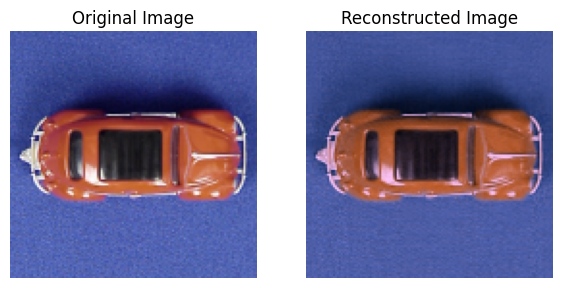

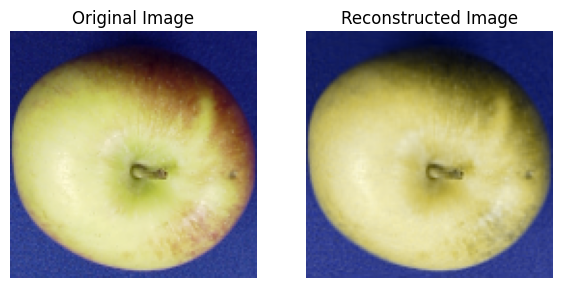

In [11]:
# Evaluate results
car_res = residual_tensor(car_tensor, car_tkd)
car_error = car_res.frob_norm / car_tensor.frob_norm
print(f"Relative error of approximation for car is {car_error}")
# Reconstruction
car_reconstruct = car_tkd.reconstruct()
# Plot original and reconstructed images side by side
plot_tensors(car_tensor, car_reconstruct)

# Evaluate results
apple_res = residual_tensor(apple_tensor, apple_tkd)
apple_error = apple_res.frob_norm / apple_tensor.frob_norm
print(f"Relative error of approximation for apple is {apple_error}")
# Reconstruction
apple_reconstruct = apple_tkd.reconstruct()
# Plot original and reconstructed images side by side
plot_tensors(apple_tensor, apple_reconstruct)

Using the tensor.shape operation on the image tensors for a car and an apple, we discover that their original size of $(128, 128, 3)$ compresses down to a core tensor size of $(50, 50, 2)$ by employing a multilinear rank. This compression cuts the total number of elements from $49,152$ to $5,000$. The multilinear rank tuple $(R1, R2, R3)$ controls how closely the Tucker form approximates the original image, with R1 and R2 affecting the spatial resolution and R3 adjusting the color depth. By diminishing the element count, the image resolution drops, leading to visible blurring, as observed on the car's frame and around the apple's stalk.

By dropping the rank $R_{3}$ for color channels from three to two, the Tucker decomposition selectively maintains only the two most significant colors in the images, thus providing a constrained color approximation. This reduction impacts the apple image more because it eliminates one of the primary apple colors contributing to the apple's surface sheen (red), which contributes less to the overall image (vs. blue in the background and green for the majority of the apple) but is still significant in representing the apple's appearance. The car image, by comparison, mostly loses the green tones, which are a lot less predominant as the car image mostly composes of the blue background and the red colour of the car. This results in color alterations such as the car's white areas appearing pink due to the normalized RGB values for white ([1 1 1]) changing to pink ([1 0 1]), signifying the removal of the green channel. Regardless, the car image still experiences a slightly higher relative approximation error compared to the apple image. This could be because the intricate details and sharp edges of the car are more affected by the resolution reduction in Tucker's approximation than the apple's smoother, more uniform shape.

### Solution: Part 2

In [12]:
# Create tensors from images
# Get data in form of a Tensor
apple_top =  get_image(item = "apple", view = "top")
top = Tensor(apple_top)

apple_side = get_image(item = "apple", view = "side")
side = Tensor(apple_side)

In [13]:
# Perform decomposition
algorithm = HOSVD()
top_tkd = algorithm.decompose(top, rank=(50, 50, 2))

algorithm = HOSVD()
side_tkd = algorithm.decompose(side, rank=(50, 50, 2))

Relative error of approximation for top view is 0.03706225838740828
Relative error of approximation for side view is 0.06574690406026351


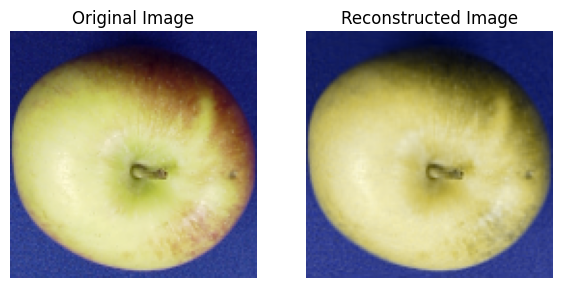

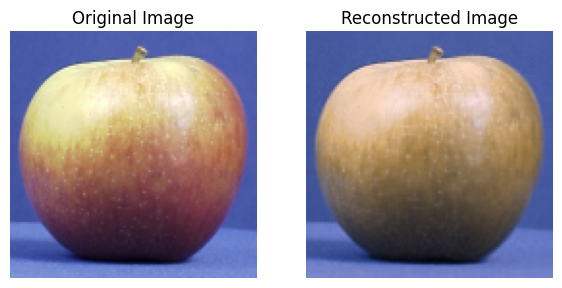

In [14]:
# Evaluate results
top_res = residual_tensor(top, top_tkd)
top_error = top_res.frob_norm / top.frob_norm
print(f"Relative error of approximation for top view is {top_error}")
# Reconstruction
top_reconstruct = top_tkd.reconstruct()
# Plot original and reconstructed images side by side
plot_tensors(top, top_reconstruct)

# Evaluate results
side_res = residual_tensor(side, side_tkd)
side_error = side_res.frob_norm / side.frob_norm
print(f"Relative error of approximation for side view is {side_error}")
# Reconstruction
side_reconstruct = side_tkd.reconstruct()
# Plot original and reconstructed images side by side
plot_tensors(side, side_reconstruct)

Observing the original apple images from side and top angles reveals a stronger red presence on the side, whereas the top view displays more green. The Tucker decomposition process, which reduces the core tensor's rank $R_{3}$ from three to two, essentially confines the color information to a two-dimensional subspace. This procedure prioritises the two most significant colors and tends to eliminate the least predominant one. Thus, in the side view where green is less prominent, it gets largely diminished in the Tucker-approximated image, resulting in a reddish-brown apple. Conversely, from the top, where red is less dominant, those tones are subdued, making way for darker greens and browns.

Moreover, the decrease in ranks $R_{1}$ and $R_{2}$ from 128 to 50 affects the overall image resolution. This not only changes the color but also blurs the distinction between the apple and its background. It is evident that the side profile of the apple suffers more in terms of relative error post-approximation, as it turns to a brownish hue, while the green tones of the top view largely remain true to the original, even after Tucker's approximation.

### Solution: Part 3

In [17]:
# Create tensors from images
car = get_image(item="car", view="top")
car_tensor = Tensor(car)

apple = get_image(item="apple", view="top")
apple_tensor = Tensor(apple)

In [19]:
# Perform decomposition
algorithm = HOSVD()
car_tkd = algorithm.decompose(car_tensor, rank=(50, 50, 1))

algorithm = HOSVD()
apple_tkd = algorithm.decompose(apple_tensor, rank=(50, 50, 1))

Relative error of approximation for car is 0.2544471822623989
Relative error of approximation for apple is 0.16727962973903548


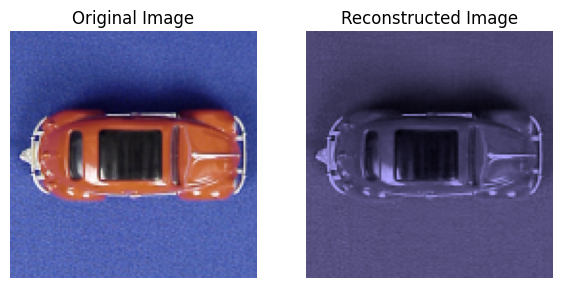

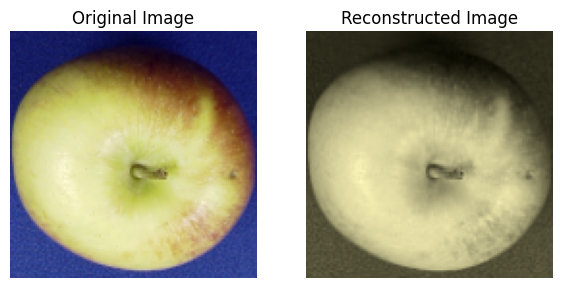

In [20]:
# Evaluate results
car_res = residual_tensor(car_tensor, car_tkd)
car_error = car_res.frob_norm / car_tensor.frob_norm
print(f"Relative error of approximation for car is {car_error}")
# Reconstruction
car_reconstruct = car_tkd.reconstruct()
# Plot original and reconstructed images side by side
plot_tensors(car_tensor, car_reconstruct)

# Evaluate results
apple_res = residual_tensor(apple_tensor, apple_tkd)
apple_error = apple_res.frob_norm / apple_tensor.frob_norm
print(f"Relative error of approximation for apple is {apple_error}")
# Reconstruction
apple_reconstruct = apple_tkd.reconstruct()
# Plot original and reconstructed images side by side
plot_tensors(apple_tensor, apple_reconstruct)

When $R_{3}$ in the multilinear rank of the core tensor is further reduced from two to one, color representation in the image is limited to a single dimension. This reduction means colors in the image are depicted along a single gradient, with the most dominant hue becoming the basis for all colors. In the case of the car image, blue is the dominant hue, so every element of the image shifts towards varying shades of blue. The apple image, having a more balanced color profile initially, shows a combined effect that results in a grayscale representation, where mixing all shades would typically yield white in RGB space, represented by [1,1,1]. There's a hint of green due to its slight predominance in the original image.

Further reduction in the number of elements in the image from 49,152 to 2,500 exacerbates the loss of resolution. This loss, together with the reduced color dimension, causes the edges of objects and their background boundaries to blur, leading to a more pronounced relative error in the car image's approximation compared to the apple's. This outcome has been demonstrated and visualized to convey the concept clearly.